In [ ]:
# pip install pandas pyarrow

In [ ]:
# pip install workalendar


In [ ]:
from workalendar.europe import France

In [ ]:
import pandas as pd

In [2]:

from sklearn.model_selection import train_test_split

def train_test_split_temporal(X, y, test_size=0.2):

    data = pd.concat([X, y], axis=1)

    data = data.sort_values('date')

    test_samples = int(len(data) * test_size)

    train_data = data[:-test_samples]
    test_data = data[-test_samples:]

    X_train, y_train = train_data.drop('log_bike_count', axis=1), train_data['log_bike_count']
    X_test, y_test = test_data.drop('log_bike_count', axis=1), test_data['log_bike_count']
    
    return X_train, X_test, y_train, y_test


def merge_weather_data(data):
    
    weather_data_path = "F:/Polytechnique/gradient-gurus-ds-project/mdsb-2023/external_data.csv"
    weather_data = pd.read_csv(weather_data_path)
    weather_data = weather_data.dropna(subset = ['date'])
    weather_data.ffill(inplace=True)
    
    new_col_names = {
        "num_sta": "station_code",
        "ff" : "avg_wind_speed",
        "t" : "temperature",
        "td" : "dew_point",
        "u" : "humidity",
        "vv" : "horizontal_visibility",
        "n" : "total_cloudiness",
        "nbas" : "lower_level_cloudiness",
        "hbas" : "height_lower_cloud_base",
        "cl" : "type_of_lower_clouds",
        "cm" : "type_of_middle_clouds",
        "ch" : "type_of_higher_clouds",
        "tn12" : "min_temp_12h",
        "tn24" : "min_temp_24h",
        "tx12" : "max_temp_12h",
        "tx24" : "max_temp_24h",
        "tminsol" : "min_soil_temp_24h",
        "raf10" : "gusts_10_mins",
        "rafper" : "gusts_for_period",
        "ground_state" : "soil_condition",
        "ht_snow" : "total_height_snow_others",
        "ssfrai" : "height_fresh_snow",
        "rr1" : "precipitation_1_hours",
        "rr3" : "precipitation_3_hours",
        "rr6" : "precipitation_6_hours",
        "rr12" : "precipitation_12_hours",
        "rr24" : "precipitation_24_hours"
    }

    weather_data.rename(columns = new_col_names, inplace=True)
    
    # List of column indices to keep
    columns_to_keep_indices = [1, 6, 7, 8, 9, 10, 14, 15, 31, 32, 33, 36, 38, 39, 40, 41, 42]

    # Use iloc to select columns based on indices
    weather_data = weather_data.iloc[:, columns_to_keep_indices]
    
    # # Replace missing values with a constant (e.g., -1)
    # numeric = weather_data.loc[:, weather_data.columns != 'date']
    # date_data = weather_data['date']
    # imputer = SimpleImputer(strategy='mean')
    # imputed_numeric_data = imputer.fit_transform(numeric)
    # imputed_numeric_data = pd.DataFrame(imputed_numeric_data)
    # date_data = pd.DataFrame(date_data)
    # weather_data = pd.concat([imputed_numeric_data, date_data], axis=0)
    # weather_data = weather_data.reset_index(drop=True)

    data['date'] = pd.to_datetime(data['date'])
    weather_data['date'] = pd.to_datetime(weather_data['date'])


    data = data.sort_values('date')
    weather_data = weather_data.sort_values('date')
    
    data['date'] = data['date'].ffill()
    

    combined_data = pd.merge_asof(data, weather_data, on='date', direction='nearest')
    combined_data = combined_data.drop(['counter_name', 'site_id', 'site_name', 'coordinates', 'counter_technical_id'], axis = 1)
    
    
    return combined_data


def is_bank_holiday(data):
    cal = France()
    data['bank_holiday'] = data['date'].apply(lambda x: cal.is_holiday(x))
    return data


def split_date(data):
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['hour'] = data['date'].dt.hour
    
    # print("This is the data DataFrame after merging weather data and extracting the year, month, day, hour")
    # data.info()

    data = data.drop(columns=["date"])

    return data


def get_numerical_data(data):
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
    numerical_data = data[numerical_cols]
    
    return numerical_data

def get_categorical_data(data):
    categorical_cols = data.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_data = data[categorical_cols]
    
    return categorical_data


                 counter_id                 counter_name    site_id  \
136950         100044493-SC  67 boulevard Voltaire SE-NO  100044493   
702124  100056332-103056332          Pont de Bercy NE-SO  100056332   
701293  100056332-103056332          Pont de Bercy NE-SO  100056332   
745484  100056335-103056335             Quai d'Orsay O-E  100056335   
663706  100056330-104056330    36 quai de Grenelle NE-SO  100056330   

                          site_name  bike_count                date  \
136950  67 boulevard Voltaire SE-NO       182.0 2020-09-21 09:00:00   
702124                Pont de Bercy        19.0 2021-04-22 04:00:00   
701293                Pont de Bercy         4.0 2021-03-16 21:00:00   
745484                 Quai d'Orsay       291.0 2020-09-24 17:00:00   
663706          36 quai de Grenelle        63.0 2021-06-04 08:00:00   

       counter_installation_date       coordinates counter_technical_id  \
136950                2018-06-27  48.86149,2.37376          Y2H18034809

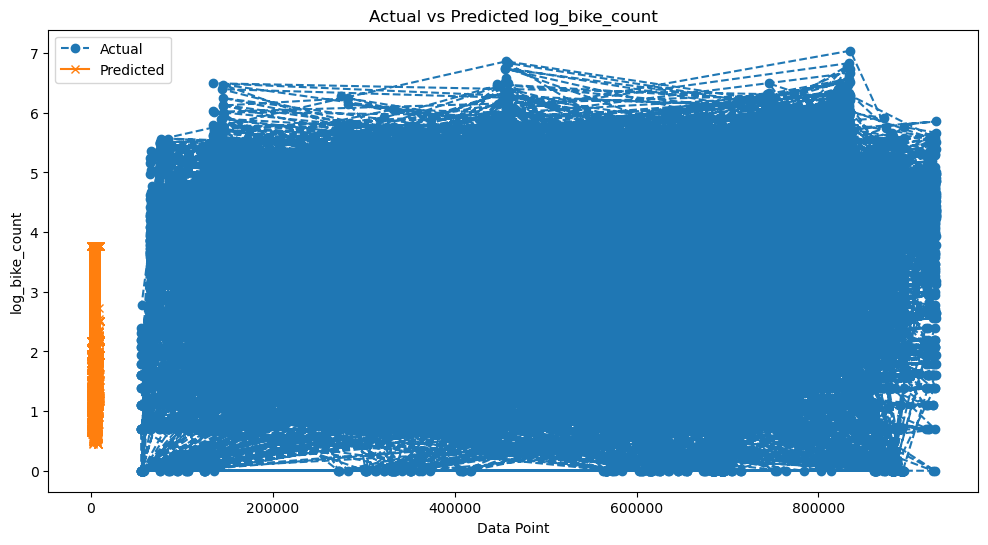

In [7]:
from workalendar.europe import France
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
import pandas as pd


train_data_path = "F:/Polytechnique/gradient-gurus-ds-project/mdsb-2023/train.parquet"
train_data = pd.read_parquet(train_data_path)
train_data.to_csv('train.csv', index=False)
train_data = train_data.sample(n=50000, random_state=42)
train_data = train_data.dropna(subset = ['date'])
print(train_data.head())

X = train_data.drop(columns = ['log_bike_count', 'bike_count'], axis=1)
y = train_data['log_bike_count']

test_data_path = "F:/Polytechnique/gradient-gurus-ds-project/mdsb-2023/final_test.parquet"
X_test_final = pd.read_parquet(test_data_path)

# Check for null values in the 'date' column of the 'data' DataFrame
null_date_rows = X_test_final[X_test_final['date'].isnull()]

print("Rows with null values in the 'date' column:")
print(null_date_rows)


X_train, X_test, y_train, y_test = train_test_split_temporal(X, y)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

weather_data_merger = FunctionTransformer(merge_weather_data)
bank_holiday_checker = FunctionTransformer(is_bank_holiday)
date_splitter = FunctionTransformer(split_date)
# num_cat_separator = FunctionTransformer(separate_numerical_categorical)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_include=['float64', 'int64'])),
        ('cat', categorical_transformer, selector(dtype_exclude=['float64', 'int64']))
    ]
)


pipeline = Pipeline([
    ('adding_weather_data', weather_data_merger),
    ('bank_holiday_checker', bank_holiday_checker),
    ('date_split', date_splitter),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])


param_grid = {
    'regressor__n_estimators': [8],
    'regressor__max_depth': [7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linestyle='--', marker='o')
plt.plot(y_pred, label='Predicted', linestyle='-', marker='x')
plt.title('Actual vs Predicted log_bike_count')
plt.xlabel('Data Point')
plt.ylabel('log_bike_count')
plt.legend()
plt.show()

In [ ]:
print(best_model)

In [ ]:
mse

In [ ]:
y_pred_final = best_model.predict(X_test_final)
to_write = pd.DataFrame({'Id': range(0, len(y_pred_final)), 'log_bike_count': y_pred_final})

to_write.to_csv('test_data_prediction.csv', index=False)

In [ ]:
X_test_final.shape

In [ ]:
to_write.info()

In [10]:
import pandas as pd

df = merge_weather_data(train_data)
df = df.select_dtypes(include=['float64', 'int64'])

correlations = df.drop('log_bike_count', axis=1).corrwith(df['log_bike_count'])

selected_features = correlations[abs(correlations) >= 0.1].index


selected_weather_data = df[selected_features]

print(selected_weather_data.head())

# import pandas as pd

# # Assuming df is your combined dataframe with bike count and weather data
# # bike_count_column is the name of the column with bike count data
# df = merge_weather_data(train_data)
# df = df.select_dtypes(include=['float64', 'int64'])

correlations = df.drop('log_bike_count', axis=1).corrwith(df['log_bike_count'])

correlation_table = pd.DataFrame({
    'Feature': correlations.index,
    'Correlation with log_bike_count': correlations.values
})


print(correlation_table)


   bike_count   latitude  avg_wind_speed  temperature  dew_point  humidity  \
0         1.0  48.846028             1.6       285.75     282.55        81   
1         1.0  48.890457             1.6       285.75     282.55        81   
2         1.0  48.842230             1.6       285.75     282.55        81   
3         0.0  48.848400             1.6       285.75     282.55        81   
4         3.0  48.840801             1.6       285.75     282.55        81   

   gusts_10_mins  gusts_for_period  
0            2.4               3.1  
1            2.4               3.1  
2            2.4               3.1  
3            2.4               3.1  
4            2.4               3.1  
                   Feature  Correlation with log_bike_count
0               bike_count                         0.736846
1                 latitude                         0.118157
2                longitude                         0.049126
3           avg_wind_speed                         0.137731
4        

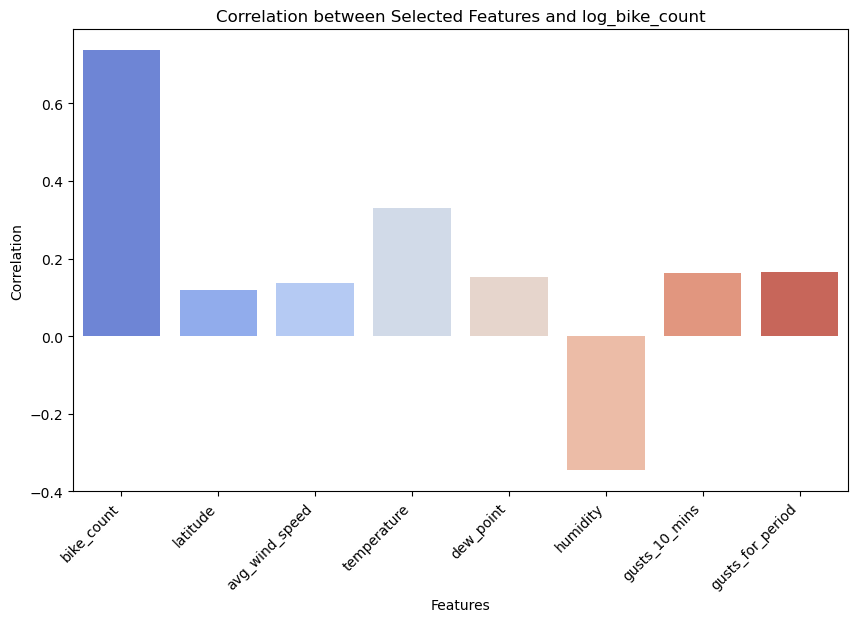

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = merge_weather_data(train_data)
df = df.select_dtypes(include=['float64', 'int64'])


correlations = df.drop('log_bike_count', axis=1).corrwith(df['log_bike_count'])

selected_features = correlations[abs(correlations) >= 0.1].index

selected_weather_data = df[selected_features]

correlations_with_target = selected_weather_data.apply(lambda x: x.corr(df['log_bike_count']))

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_target.index, y=correlations_with_target.values, palette="coolwarm")
plt.title('Correlation between Selected Features and log_bike_count')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


In [ ]:
pip install xgboost

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from workalendar.europe import France


df_train = pd.read_parquet("F:/Polytechnique/gradient-gurus-ds-project/mdsb-2023/train.parquet")
df_test = pd.read_parquet("F:/Polytechnique/gradient-gurus-ds-project/mdsb-2023/final_test.parquet")


def split_date(data):
    
    # Get integer values of hours, day, month and year from the date column
    data = data.copy()
    
    data["hour"] = data["date"].dt.hour
    data["day"] = data["date"].dt.day
    data["weekday"] = data["date"].dt.weekday
    data["month"] = data["date"].dt.month
    data["year"] = data["date"].dt.year
    
    # Mark the days which are bank holidays in France
    cal = France()
    data['bank_holiday'] = data['date'].apply(lambda x: cal.is_holiday(x))

    # Drop date
    return data.drop(columns=["date"])


def merge_weather_data(data):
    file_path = "F:/Polytechnique/gradient-gurus-ds-project/mdsb-2023/external_data.csv"
    weather_data = pd.read_csv(file_path, parse_dates=["date"])

    data['date'] = pd.to_datetime(data['date']).astype('datetime64[ns]')
    weather_data['date'] = pd.to_datetime(weather_data['date']).astype('datetime64[ns]')

    data = data.copy()

    # Merge weather data and save information on original order of tuples
    data["sorting_index"] = np.arange(data.shape[0])
    data = pd.merge_asof(
        data.sort_values("date"), 
        weather_data[["date", "t", 'u', 'ff', 'td', 'raf10', 'rafper']].sort_values("date"), 
        on="date"
    )

    # Sort the dataframe to the original order
    data = data.sort_values("sorting_index")
    del data["sorting_index"]
    return data


# Get training data
df_train = merge_weather_data(df_train)
date_values = split_date(df_train[["date"]])
df_train = pd.concat([df_train, date_values], axis=1)

# Get testing data
df_test = merge_weather_data(df_test)
test_date_values = split_date(df_test[["date"]])
df_test = pd.concat([df_test, test_date_values], axis=1)

# Split X and y from training data
y_train = df_train['log_bike_count']
X_train = df_train.drop('log_bike_count', axis=1)

# Specify column to encode and passthrough
categorical_encoder = OrdinalEncoder()
categorical_cols = ["counter_name", "bank_holiday"]
passthrough_cols = ['latitude', 'longitude', 't', 'u', 'ff', 'td', 'raf10', 'rafper', 'month', 'weekday', 'hour', 'day']

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_encoder, categorical_cols),
        ('passthrough', 'passthrough', passthrough_cols)
    ]
)

# Use parameters obtained from the GridSearch to initialise XGBRegressor
regressor = XGBRegressor(
    learning_rate=0.1, 
    max_depth=8, 
    n_estimators=500,
    min_child_weight=5, 
    reg_alpha=0.1, 
    colsample_bytree=0.8
)


# param_grid = {
#     'xgbregressor__learning_rate': [0.1],
#     'xgbregressor__max_depth': [8],
#     'xgbregressor__n_estimators': [100],
#     'xgbregressor__gamma': [0],
#     'xgbregressor__min_child_weight': [5],
#     'xgbregressor__reg_alpha': [0.1, 0.15, 0.2],
#     'xgbregressor__colsample_bytree': [0.8, 0.9, 1],
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)

# # Make predictions with the best model
# y_pred = best_model.predict(df_test)


# Create pipeline and train
pipeline = make_pipeline(preprocessor, regressor)
pipeline.fit(X_train, y_train)

# Predict and save result
y_pred = pipeline.predict(df_test)


final_pred = pd.DataFrame(dict(Id=np.arange(y_pred.shape[0]), log_bike_count=y_pred))
final_pred.to_csv("submission.csv", index=False)
